
#Pre -trained Turkish BERT

https://github.com/stefan-it/turkish-bert

bert-base-turkish-cased



#1)Setting up the GPU usage
If you are using colabs please change runtime type to GPU, otherwise it would take a while to run this code


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('The GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
The GPU: Tesla P100-PCIE-16GB


**Importing libraries and modules that are going to be used**

In [ ]:
from random import Random
import copy
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder



Now I am going to start creating the data sets with the methods I have suggested at the beginning of the notebook

I will create 1000 samples for each categories, probably less for hobbies since I will scrap it from web 




#2)Creating credit cards data set
**CAUTION: I TOOK BELOW CODE TO CREATE SAMPLE CREDIT CARDS FROM GITHUB**

The code uses Luhn Algorithm to generate credit card numbers and also take into account of MII and BIN (Major industry identifier, Bank Identification Number)

https://github.com/eye9poob

In [ ]:

visaPrefixList = [
        ['4', '5', '3', '9'],
        ['4', '5', '5', '6'],
        ['4', '9', '1', '6'],
        ['4', '5', '3', '2'],
        ['4', '9', '2', '9'],
        ['4', '0', '2', '4', '0', '0', '7', '1'],
        ['4', '4', '8', '6'],
        ['4', '7', '1', '6'],
        ['4']]

mastercardPrefixList = [
        ['5', '1'], ['5', '2'], ['5', '3'], ['5', '4'], ['5', '5']]



def completed_number(prefix, length):
    """
    'prefix' is the start of the CC number as a string, any number of digits.
    'length' is the length of the CC number to generate. Typically 13 or 16
    """

    ccnumber = prefix

    # generate digits

    while len(ccnumber) < (length - 1):
        digit = str(generator.choice(range(0, 10)))
        ccnumber.append(digit)

    # Calculate sum

    sum = 0
    pos = 0

    reversedCCnumber = []
    reversedCCnumber.extend(ccnumber)
    reversedCCnumber.reverse()

    while pos < length - 1:

        odd = int(reversedCCnumber[pos]) * 2
        if odd > 9:
            odd -= 9

        sum += odd

        if pos != (length - 2):

            sum += int(reversedCCnumber[pos + 1])

        pos += 2

    # Calculate check digit

    checkdigit = ((sum / 10 + 1) * 10 - sum) % 10

    ccnumber.append(str(checkdigit))

    return ''.join(ccnumber)


def credit_card_number(rnd, prefixList, length, howMany):

    result = []

    while len(result) < howMany:

        ccnumber = copy.copy(rnd.choice(prefixList))
        result.append(completed_number(ccnumber, length))

    return result



generator = Random()
generator.seed()        # Seed from current time

mastercard = credit_card_number(generator, mastercardPrefixList, 16, 500)

visa16 = credit_card_number(generator, visaPrefixList, 16, 500)

credit_card = mastercard + visa16

In [ ]:
import pandas as pd
df=pd.DataFrame(credit_card, columns=['data_pool']) 

df['data_pool']=df['data_pool'].astype(str).astype(float).astype(int)
df['labels'] = 'credit_card_number'

#3)Creating the blood_type Data Set

I have just googled all blood types and wrote them in different styles (symbols or strings ) then I cloned the array that I created in order to make the balanced data pool in terms of different categories

In [ ]:
import numpy as np
kan_grupları= np.array(['0 RH+','0 RH Positive',' 0 RH-','0 RH Negative',' AB RH+','AB RH Positive','AB RH-','AB RH Negative','A RH+','A RH Positive', 'A RH-','A RH Negative', 'B RH+','B RH Positive',' B RH-','B RH Negative'])

In [ ]:
kan_grupları=np.repeat(kan_grupları, 70)

In [ ]:
kg=pd.DataFrame(kan_grupları, columns=['data_pool'])
kg['labels'] = 'blood_type'

In [ ]:
data_pool=pd.concat([kg,df], axis=0)

#4) Creating Republic of Turkey Identification Numbers Data Set
According to my search from different sources on web I have concluded below rule is correct to generate Turkish Id with 11 numbers.

First 9 numbers are expressed with d, last 2 numbers are control numbers and expressed as c1 c2 :

c1 = ( (d1 + d3 + d5 + d7 + d9) * 7 - (d2 + d4 + d6 + d8) ) mod10

c2 = ( d1 + d2 + d3 + d4 + d5 + d6 + d7 + d8 + d9 + c1 ) mod10

In [ ]:
import random
def is_valid(tc_id):
    tc_id = str(tc_id)
    if int(tc_id[0]) > 0 and len(tc_id) == 11:
        c2 = sum(map(int, tc_id[0:10])) % 10
        if c2 == int(tc_id[10]):
            c1 = (sum(map(int, tc_id[:10:2])) * 7-(
                           sum(map(int, tc_id[1:9:2])))) % 10
            return c1 == int(tc_id[9])

    return False
    
def generate_tc_id(limit, start= 10000000000):
    tc_ids = []
    num = start
    while len(tc_ids) < limit:
        if is_valid(num):
            tc_ids.append(num)
            num += random.randint(1,1000000)
        num +=random.randint(1,1000000)
    return tc_ids 

In [ ]:
valid_tc_numbers= generate_tc_id(limit=1000)

In [ ]:
tc_num=pd.DataFrame(valid_tc_numbers, columns=['data_pool'])
tc_num['labels'] = 'republic_of_turkey_identity_number'

In [ ]:
data_pool=pd.concat([data_pool,tc_num], axis=0)

In [ ]:
pd.set_option('display.max_rows', data_pool.shape[0]+1)

#5)Creating Phone Number Data Set
I wrote smilar algorithm to the algorithm used for credit card just added dial code and removed luhn algorithm

The country calling code of Turkey is 90. And generated approximately 300 from each gsm operator

Language digit: 0 (Direct Dialing)

Language digit: 2 (Operator Assistance)

National (significant) number: 10 Digits.

Area code: 3 digits

Local subscriber's number: 7 digits.

USED BY	CODE

Turkcell	530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 561

Vodafone	540, 541, 542, 543, 544, 545, 546, 547, 548, 549

Turk Telekom	500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559

In [ ]:
turkish_dial_code=[['+', '9', '0'],
        ['0'],
        []]

TurkTelekomPrefixList = [
        ['5', '0', '0'],
        ['5', '0', '1'],
        ['5', '0', '2'],
        ['5', '0', '3'],
        ['5', '0', '4'],
        ['5', '0', '5'],
        ['5', '0', '6'],
        ['5', '0', '7'],
        ['5', '0', '8'],
        ['5', '0', '9'],
        ['5', '5', '0'],
        ['5', '5', '1'],
        ['5', '5', '2'],
        ['5', '5', '3'],
        ['5', '5', '4'],
        ['5', '5', '5'],
        ['5', '5', '6'],
        ['5', '5', '7'],
        ['5', '5', '8'],
        ['5', '5', '9']]
VodafonePrefixList = [
        ['5', '4', '0'],
        ['5', '4', '1'],
        ['5', '4', '2'],
        ['5', '4', '3'],
        ['5', '4', '4'],
        ['5', '4', '5'],
        ['5', '4', '6'],
        ['5', '4', '7'],
        ['5', '4', '8'],
        ['5', '4', '9']]
TurkcellPrefixList = [
        ['5', '3', '0'],
        ['5', '3', '1'],
        ['5', '3', '2'],
        ['5', '3', '3'],
        ['5', '3', '4'],
        ['5', '3', '5'],
        ['5', '3', '6'],
        ['5', '3', '7'],
        ['5', '3', '8'],
        ['5', '3', '9'],
        ['5', '6', '1'],
        ] 

def completed_number(code,prefix,length):

    dial_code=code
    mobile_code = prefix

    while len(mobile_code) < (length - 1):
        
        digit = str(generator.choice(range(0, 10)))
        mobile_code.append(digit)
    return (''.join(dial_code)+''.join(mobile_code))

def phone_number(rnd,dial_code, prefixList, length, howMany):

    result = []

    while len(result) < howMany:
        code=copy.copy(rnd.choice(dial_code))
        mobile_code= copy.copy(rnd.choice(prefixList))
        result.append(completed_number(code,mobile_code,length))

    return result


generator = Random()
generator.seed()        

turktelekom = phone_number(generator,turkish_dial_code,TurkTelekomPrefixList,11,340)
turkcell = phone_number(generator,turkish_dial_code,TurkcellPrefixList,11,330)
vodafone = phone_number(generator,turkish_dial_code,VodafonePrefixList,11,330)

phone_number=turktelekom +turkcell + vodafone

In [ ]:
phone_number=pd.DataFrame(phone_number, columns=['data_pool'])
phone_number['labels'] = 'phone_number'

In [ ]:
data_pool=pd.concat([data_pool,phone_number], axis=0)

#6) Creating Amount Data Set

I m going to randomly generate numbers in a range then add TL, USD, $ ... as a prefix suffix

In [ ]:
prefix = [[],
        ['$'],
        ['₺'],
        ['€']] 
suffix= [[],
        ['TL'],
        ['USD'],
        ['EUR']] 

def completed_number(prefix):

    symbols = prefix
    digit = str(generator.choice(range(0, 1000000)))
    prefix.append(digit)
    return (''.join(prefix))

def amount(rnd,prefixList,howMany):

    result = []

    while len(result) < howMany:
        symbols= copy.copy(rnd.choice(prefix))
        result.append(completed_number(symbols))

    return result


generator = Random()
generator.seed()        

prefix_amount = amount(generator,prefix,500)

#Below is code dublicate I just could not figure out the random choice of suffix or prefix in same functions so, gone with the brute force approach

def currency_completed_number(suffix):

    currency = suffix
    digit = str(generator.choice(range(0, 1000000)))
    currency.insert(0,digit)
    return (' '.join(currency))

def currency_amount(rnd,prefixList,howMany):

    result = []

    while len(result) < howMany:
        symbols= copy.copy(rnd.choice(suffix))
        result.append(currency_completed_number(symbols))

    return result
suffix_amount=currency_amount(generator,suffix,500)

Amount= prefix_amount + suffix_amount

In [ ]:
amount=pd.DataFrame(Amount, columns=['data_pool'])
amount['labels'] = 'amount'

In [ ]:
data_pool=pd.concat([data_pool,amount], axis=0)

#7) Creating Hobbies Data Set

I have used web crawler extention of google chrome and got turkish hobies data
 
from this web site https://tavsiyelist.com/hobi-onerileri/ in txt format

I am just going to read line by line and put each line into hobies data frame row.



In [ ]:
import pandas as pd
col_name=['data_pool']
df = pd.read_csv('hobiler.txt', names=col_name,header = None)
df['data_pool'] = df['data_pool'].str.replace('\W{1,}',' ')
df['data_pool'] = df['data_pool'].str.replace('\d{1,}',' ')
df['labels'] = 'hobbies'

In [ ]:
df.head()

,data_pool,labels
0,Spor Yapmak,hobbies
1,Yürüyüş Yapmak Koşmak,hobbies
2,Yüzmek,hobbies
3,Oyun Oynamak,hobbies
4,Bisiklet Sürmek,hobbies


In [ ]:
data_pool=pd.concat([data_pool,df], axis=0)

In [ ]:
data_pool=data_pool.reset_index(drop=True)

In [ ]:
data_pool.to_excel("datapool.xlsx") 

In [ ]:
data_pool = data_pool.sample(frac=1).reset_index(drop=True)

In [ ]:
data_pool.head(10)

,data_pool,labels
0,AB RH-,blood_type
1,+905405994850,phone_number
2,5472086783681820,credit_card_number
3,5490899178715730,credit_card_number
4,5153395469878190,credit_card_number
5,22437920324,republic_of_turkey_identity_number
6,58203288534,republic_of_turkey_identity_number
7,12383812200,republic_of_turkey_identity_number
8,5564016458,phone_number
9,₺659836,amount


In [ ]:
data_pool['data_pool'] = data_pool['data_pool'].astype(str)
#data_pool['data_pool'] = data_pool['data_pool'].str.upper()

In [ ]:
data_pool['encoded_categories'] = LabelEncoder().fit_transform(data_pool['labels'])
data_pool=data_pool.drop(['labels'], axis=1)

In [ ]:
data_pool.shape

(5227, 2)

#8)Fine-tuning with Turkish BERT
Declaration
 Before this case study I havent worked on BERT model. After this task assigned,
I have done little research about BERT, I knew that it was popularly being used last 2 years however, I have not done any work on BERT. These are the papers and notebooks I read before I start the fine tuning Task.


 https://nlp.seas.harvard.edu/2018/04/03/attention.html

 http://mccormickml.com/tutorials/

 https://arxiv.org/abs/1810.04805

Acknowledgement 

I have also used below medium post to fine tune Turkish Bert

 https://medium.com/@toprakucar/bert-modeli-ile-t%C3%BCrk%C3%A7e-metinlerde-s%C4%B1n%C4%B1fland%C4%B1rma-yapmak-260f15a65611

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)
sentences = data_pool.data_pool.values
max_len = 250

In [ ]:
#creating train and test sets
training = data_pool.groupby('encoded_categories').apply(lambda x : x.sample(frac = 0.80))
test = pd.concat([data_pool,training]).drop_duplicates(keep=False)

print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.data_pool.values
training_labels = training.encoded_categories.values

Training:  4182
Test:  821


In [ ]:
# Tokenization process:

input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)


In [ ]:
#data loader to use tensor data on model 
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = len(data_pool['encoded_categories'].unique())

# downloading pretrained Bert model from Huggingface

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

In [ ]:

epochs = 4

# Learning rate optimization
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
criterion = torch.nn.CrossEntropyLoss()

**Training**

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

model.train()
  
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0


    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        out = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        # import pdb; pdb.set_trace()
        logit = out.logits
        loss = out.loss
        
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    10  of    112.    Elapsed: 0:00:08.
Batch    20  of    112.    Elapsed: 0:00:15.
Batch    30  of    112.    Elapsed: 0:00:23.
Batch    40  of    112.    Elapsed: 0:00:31.
Batch    50  of    112.    Elapsed: 0:00:39.
Batch    60  of    112.    Elapsed: 0:00:46.
Batch    70  of    112.    Elapsed: 0:00:54.
Batch    80  of    112.    Elapsed: 0:01:02.
Batch    90  of    112.    Elapsed: 0:01:09.
Batch   100  of    112.    Elapsed: 0:01:17.
Batch   110  of    112.    Elapsed: 0:01:25.
Average training loss: 0.67
Training epoch took: 0:01:26
======== Epoch 2 / 4 ========
Batch    10  of    112.    Elapsed: 0:00:08.
Batch    20  of    112.    Elapsed: 0:00:15.
Batch    30  of    112.    Elapsed: 0:00:23.
Batch    40  of    112.    Elapsed: 0:00:31.
Batch    50  of    112.    Elapsed: 0:00:39.
Batch    60  of    112.    Elapsed: 0:00:46.
Batch    70  of    112.    Elapsed: 0:00:54.
Batch    80  of    112.    Elapsed: 0:01:02.
Batch    90  of    112.    E

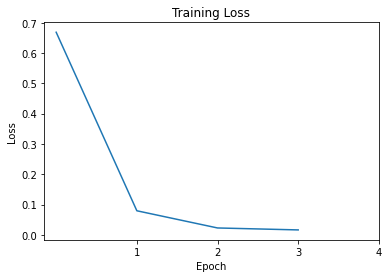

In [ ]:
# Change in loss
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

**Evaluation on Test Data**

In [ ]:
test_texts = test.data_pool.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)


prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

**Test Results**

I was not expecting that good results, so maybe overfit due to data size that I have created.  

On the other hand I am not sure if we needed to use BERT model to differentiate these data groups since I learnt how these data created I can check if they belong to certain category by is_valid function that I would write according to the rules. (for example luhn algorithm for credit card). Yet, I see the point to use BERT on hobbies data set.

In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'amount',
                          '1':'blood_type',
                          '2':'credit_card_number',
                          '3':'hobbies',
                          '4':'phone_number',
                          '5':'republic_of_turkey_id_number'})

report

F-Score:  0.9986666518516871
Recall:  0.9986666666666666
Precision:  0.9986754966887418


,amount,credit_card_number,hobbies,phone_number,republic_of_turkey_id_number,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,0.993377,1.000000,0.998377,0.998675,0.998387
recall,1.0,1.0,1.0,1.000000,0.993333,0.998377,0.998667,0.998377
f1-score,1.0,1.0,1.0,0.996678,0.996656,0.998377,0.998667,0.998377
support,300.0,300.0,32.0,300.000000,300.000000,0.998377,1232.000000,1232.000000


**Zeynep Seda Birinci** 